In [1]:
import pandas as pd
import numpy as np 
import matplotlib as mlp 
from matplotlib import pyplot as plt 
import geopandas as gp
import xlrd 
import os
import seaborn as sns

%matplotlib inline

In [2]:
os.chdir("../../core")
import GT_helper_functions as hf
import GT_load_data as data

base_dir = "../../"

In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200
sns.set_style("whitegrid")

In [4]:
def tryFunc(f, defValue = np.NaN):
    def wrap(i):
        try:
            return f(i)
        except:
            return defValue
    return wrap 

In [48]:
spendData = pd.read_csv(base_dir + "Resource Tracking/SICOIN GT/SICOIN 2011-2018.csv", index_col=0)

In [49]:
spendData.head(1)

,cod_entidad,entidad,cod_ft_org_cor,ft_org_cor,cod_subprograma,subprograma,cod_actividad_o,actividad_o,cod_renglon,renglon,cod_municipio,municipio,ASIGNADO,MODIFICADO,VIGENTE,PRE_COMPROMISO,COMPROMETIDO,DEVENGADO,PAGADO,SALDO_POR_COMPROMETER,SALDO_POR_DEVENGAR,SALDO_POR_PAGAR,PorcentajeEJEC,Year,finsource,disease,Source
0,11130009,MINISTERIO DE SALUD PÚBLICA Y ASISTENCIA SOCIAL,11 0000 000,INGRESOS CORRIENTES,18 00,SIN SUBPROGRAMA,18 00 000 001 000,PERSONA BENEFICIADA CON ACCIONES DE PREVENCIÓN...,11,PERSONAL PERMANENTE,101,GUATEMALA,973812.0,24378.0,998190.0,0.0,947080.1,947080.1,947080.1,51109.9,51109.9,0.0,94.879742,2017.0,GHE,Malaria,GHE


In [61]:
inputsData = pd.read_csv(base_dir + "Resource Tracking/SICOIN GT/SICOIN GF Inputs - 2010-2018.csv", index_col=0)

In [74]:
inputsData.groupby(["Grant", "Year"]).Fuente.value_counts()

Grant             Year    Fuente          
FM-GTM-T-MSPAS    2016.0  61 - 0425 - 0003    1
                  2017.0  61 - 0425 - 0003    1
                  2018.0  61 - 0425 - 0003    5
FM-GUA-311-G06-H  2011.0  61 - 0425 - 0001    2
                  2014.0  61 - 0425 - 0001    1
                  2015.0  61 - 0425 - 0001    3
                  2016.0  61 - 0425 - 0001    5
                  2017.0  61 - 0425 - 0001    4
FM-GUA-610-G04-T  2012.0  61 - 2102 - 0013    1
                  2013.0  61 - 2102 - 0013    1
                  2014.0  61 - 2102 - 0013    2
                  2015.0  61 - 2102 - 0013    1
FM-GUA-M-MSPAS    2011.0  61 - 0425 - 0002    1
                  2012.0  61 - 0425 - 0002    1
                  2014.0  61 - 0425 - 0002    3
                  2015.0  61 - 0425 - 0002    2
                  2016.0  61 - 0425 - 0002    1
                  2017.0  61 - 0425 - 0002    4
                  2018.0  61 - 0425 - 0002    5
GUA-610-G04-T     2010.0  61 - 2102 - 0013   

In [50]:
grantsFM = ["61 0425 001", "61 2102 013", "61 0425 002", "61 2102 013", "61 0425 003"]
#spendData.groupby(["cod_ft_org_cor", "ft_org_cor"]).DEVENGADO.sum()
# Fix GF spending classification
spendData["Source"] = spendData.apply(lambda x: "Global Fund" if x.cod_ft_org_cor in grantsFM else x.Source, 1)

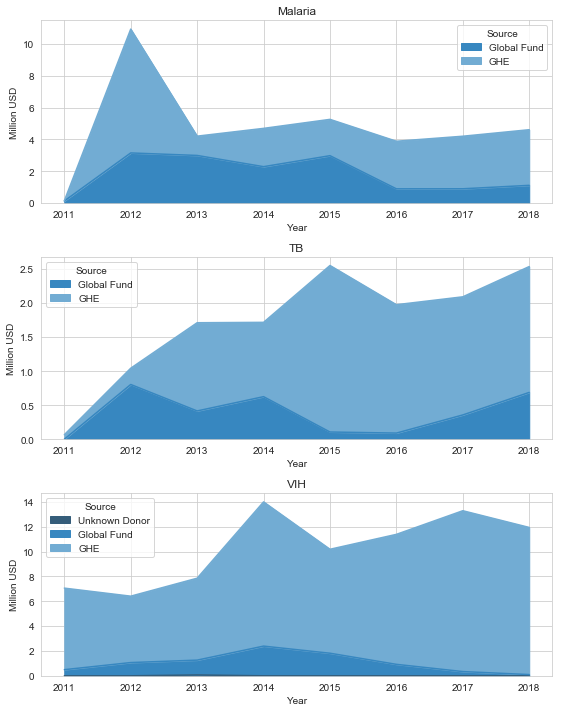

In [57]:
mlp.rcParams['figure.figsize'] = [8, 10]

temp = spendData.groupby(["Year", "disease", "Source"])\
    .DEVENGADO.sum()[lambda x: x>0].unstack([1, 2]).divide(7.5*1000000).sort_index(axis="columns", ascending=False).fillna(0)

levels = temp.columns.get_level_values(1).unique()
pal = sns.color_palette("Blues_d", n_colors = len(levels), )
levelsColors = dict(zip(levels, pal))

for i,disease in zip(range(1,4), ["Malaria", "TB", "VIH"]):
    ax = plt.subplot(3,1,i)
    temp[(disease)].plot.area(ax = ax, color = [levelsColors[x] for x in temp[(disease)].columns.values])
    ax.set_title(disease)
    ax.set_ylabel("Million USD")

plt.tight_layout()

Text(0,0.5,'Cumulative - Millions (Q)')

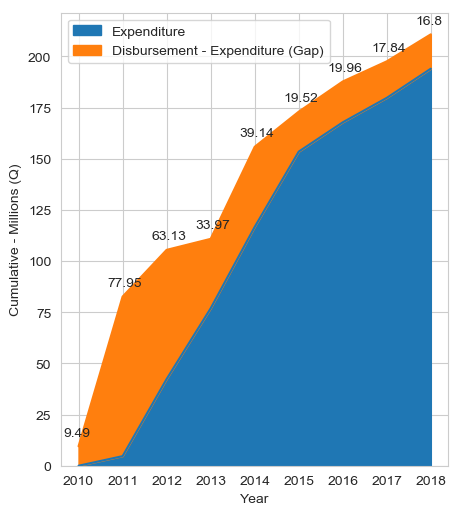

In [97]:
mlp.rcParams["figure.figsize"] = (5,6)
mlp.rcParams["figure.dpi"] = 100
# Comparing input to spending
temp = pd.concat([inputsData.groupby("Year").Monto.sum().cumsum(),
           spendData[spendData.Source == "Global Fund"].groupby("Year").DEVENGADO.sum().cumsum()
          ], 1).fillna(0)

temp["Disbursement - Expenditure (Gap)"] = temp.Monto - temp.DEVENGADO
temp["Expenditure"]  =temp.DEVENGADO
(temp/1000000)[["Expenditure", "Disbursement - Expenditure (Gap)"]].plot.area()
for i, row in temp.iterrows():
    plt.text(i-0.35, 5+row.Monto/1000000, str((row["Disbursement - Expenditure (Gap)"]/1e6).round(2)))
plt.ylabel("Cumulative - Millions (Q)")

In [77]:
temp

,Monto,DEVENGADO
Year,,
2010.0,9.489981e+06,0.000000e+00
2011.0,8.262632e+07,4.680799e+06
2012.0,1.054810e+08,4.235244e+07
2013.0,1.108623e+08,7.689639e+07
2014.0,1.558316e+08,1.166890e+08
2015.0,1.730050e+08,1.534839e+08
2016.0,1.877582e+08,1.678012e+08
2017.0,1.976056e+08,1.797631e+08
2018.0,2.108063e+08,1.940101e+08
